# Load Dependencies

In [1]:
import pandas as pd
import numpy as np
import glob

from rdkit import Chem
from rdkit.Chem import AllChem

from morfeus import Sterimol,BuriedVolume,read_xyz

from script.read_FOMO import read_FOMO
from script.charge import read_charge
from script.bond import gen_alk_bond_length_map,gen_sub_bond_length_map,gen_acid_bond_length_map
from script.wbo import gen_bond_wbo_map
from script.utils import maxminscale

# Load Data

In [2]:
data=pd.read_csv('./data/data.csv')

sub_smi=data['Substrate SMILES'].to_list()
alk_smi=data['Alkene SMILES'].to_list()
acid_smi=data['Acid SMILES'].to_list()

sub_smi_set=set(sub_smi)
alk_smi_set=set(alk_smi)
acid_smi_set=set(acid_smi)

temp=np.array(data[ 'Temp /C'].to_list())[:69]+273.15
ee= np.array(data['ee'].to_list())/100
ee= np.array(ee[:69])
ddg=np.array(-8.314*temp*np.log((1-ee)/(1+ee))/4184)

tem=maxminscale(np.array(data['Temp /C'].to_list())).reshape(-1,1)

for index,i in enumerate(acid_smi[:69]):
    for j in acid_smi[69:]:
        if Chem.MolToSmiles(Chem.MolFromSmiles(i))==Chem.MolToSmiles(Chem.MolFromSmiles(j)) and i!=j:
            acid_smi[index]=j
            
acid_smi_set=set(acid_smi)
acid_index=list(range(59,69))

# Show 10 CCAs of rxn2

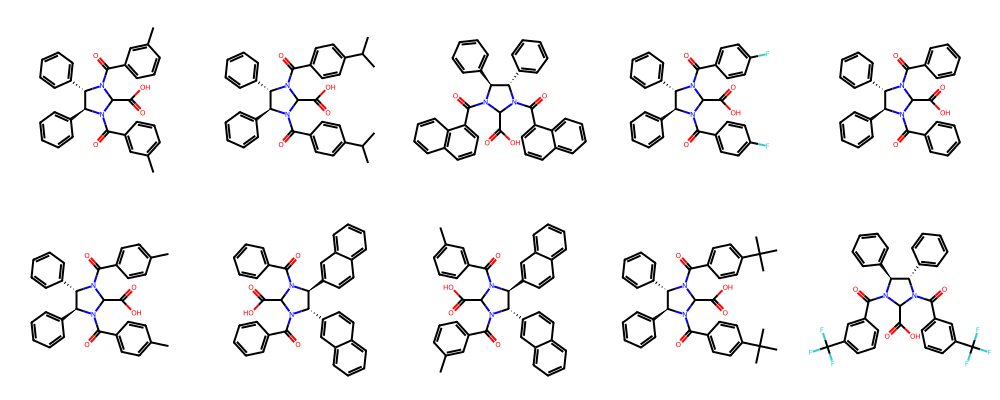

In [3]:
mol=[]
for i in set(set(acid_smi[59:69])):
    mol.append(Chem.MolFromSmiles(i)) 
from rdkit.Chem import Draw#[50:92]
img = Draw.MolsToGridImage(mol,molsPerRow=5,subImgSize=(200,200),legends=['' for x in mol])
img

# Generate Descriptors

## Buried Volume and Sterimol

In [4]:
xyz_fn_map = pd.read_csv('./data/smiles_file_dict.csv')
match_idx = pd.read_csv('./data/match_index.csv')

smiles_fn_map = {str(fn):smi for fn,smi in zip(xyz_fn_map['file_name'].to_list(),xyz_fn_map['SMILES'].to_list())}

smiles_match_idx_map = {smi:list(map(eval,str(idx).split('-'))) for smi,idx in zip(match_idx['SMILES'].to_list(),match_idx['match_index'].to_list())}
fn_smiles_map = {smiles_fn_map[key]:key for key in smiles_fn_map}
smiles_ele_pos_map={}

for f in glob.glob('.\\data\\xyz_data\\*'):
    smiles_ele_pos_map[smiles_fn_map[f.split('\\')[-1]]]=read_xyz(f+'\\xtbopt.xyz')

In [5]:
Desc_map = {}
Desc_map['sub'] = {}

for smi in sub_smi_set:

    match_index = smiles_match_idx_map[smi]
    element,positions = smiles_ele_pos_map[smi]
    tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))

    atom = tmp_mol.GetAtomWithIdx(match_index[4])
    index2=list(set([x.GetIdx() for x in atom.GetNeighbors()])-set(list([match_index[0]])+list([match_index[3]])))
    sterimol = Sterimol(element,positions,match_index[4]+1,index2[0]+1)
    bv1 = BuriedVolume(element,positions,match_index[4]+1)
    B1 = sterimol.B_1_value
    B5 = sterimol.B_5_value
    L = sterimol.L_value
    BV = bv1.fraction_buried_volume
    Desc_map['sub'][smi] = np.array([B1,B5,L,BV])

    print(fn_smiles_map[smi],match_index[4]+1,index2[0]+1)

sub_4 6 9
sub_5 5 6
sub_9 5 4
sub_2 5 6
sub_11 7 10
sub_6 8 7
sub_3 13 14
sub_1 10 11
sub_8 6 9
sub_10 6 9
sub_7 6 9
sub_0 5 6


In [6]:
Desc_map['acid'] = {}
for smi in acid_smi_set:
    try:
        tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))
        match_index = smiles_match_idx_map[smi]
        element,positions = smiles_ele_pos_map[smi]

        sterimol = Sterimol(element,positions,match_index[1]+1,match_index[2]+1)
        bv1 = BuriedVolume(element,positions,match_index[3]+1)
        bv2 = BuriedVolume(element,positions,match_index[2]+1)
        B1_1 = sterimol.B_1_value
        B5_1 = sterimol.B_5_value###
        L_1 = sterimol.L_value
        BV1_1 = bv1.fraction_buried_volume
        BV2_1 = bv2.fraction_buried_volume

        sterimol = Sterimol(element,positions,match_index[9]+1,match_index[10]+1)
        bv1 = BuriedVolume(element,positions,match_index[8]+1)
        bv2 = BuriedVolume(element,positions,match_index[10]+1)
        B1_2 = sterimol.B_1_value
        B5_2 = sterimol.B_5_value
        L_2 = sterimol.L_value
        BV1_2 = bv1.fraction_buried_volume
        BV2_2 = bv2.fraction_buried_volume

        atom = tmp_mol.GetAtomWithIdx(match_index[14])  
        sterimol = Sterimol(element,positions,match_index[14]+1,match_index[15]+1)
        bv1 = BuriedVolume(element,positions,match_index[14]+1)
        bv2 = BuriedVolume(element,positions,match_index[15]+1)
        B1_3 = sterimol.B_1_value
        B5_3 = sterimol.B_5_value
        L_3 = sterimol.L_value
        BV1_3 = bv1.fraction_buried_volume
        BV2_3 = bv2.fraction_buried_volume

        atom = tmp_mol.GetAtomWithIdx(match_index[12]) 
        sterimol = Sterimol(element,positions,match_index[12]+1,match_index[13]+1)
        bv1 = BuriedVolume(element,positions,match_index[12]+1)
        bv2 = BuriedVolume(element,positions,match_index[13]+1)
        B1_4 = sterimol.B_1_value
        B5_4 = sterimol.B_5_value
        L_4 = sterimol.L_value
        BV1_4 = bv1.fraction_buried_volume
        BV2_4 = bv2.fraction_buried_volume

        Desc_map['acid'][smi] = np.array([B1_1,B5_1,L_1,BV1_1,BV2_1,B1_2,B5_2,L_2,BV1_2,BV2_2,B1_3,B5_3,L_3,BV1_3,BV2_3,B1_4,B5_4,L_4,BV1_4,BV2_4])

        print(fn_smiles_map[smi],match_index[1]+1,match_index[2]+1,match_index[3]+1)
    except:
        pass
        #print(smi)

acid_133 16 17 15
acid_235 24 25 23
acid_169 24 25 23
acid_28 24 25 23
acid_375 24 25 23
acid_370 24 25 23
acid_296 24 25 23
acid_405 20 21 19
acid_147 24 25 23
acid_53 24 25 23
acid_207 24 25 23
acid_459 20 21 19
acid_124 16 17 15
acid_75 16 17 15
acid_91 24 25 23
acid_164 24 25 23
acid_354 24 25 23
acid_263 24 25 23
acid_284 24 25 23
acid_192 16 17 15
acid_335 20 21 19
acid_60 20 21 19
acid_62 24 25 23
acid_383 16 17 15
acid_338 24 25 23
acid_78 20 21 19
acid_68 24 25 23
acid_463 24 25 23
acid_448 20 21 19
acid_396 24 25 23
acid_81 16 17 15
acid_99 20 21 19
acid_64 24 25 23
acid_345 20 21 19
acid_245 24 25 23
acid_74 24 25 23
acid_326 24 25 23
acid_256 24 25 23
acid_285 20 21 19
acid_475 20 21 19
acid_240 24 25 23
acid_120 24 25 23
acid_151 16 17 15
acid_13 24 25 23
acid_319 24 25 23
acid_63 24 25 23
acid_462 24 25 23
acid_145 24 25 23
acid_232 16 17 15
acid_377 24 25 23
acid_250 24 25 23
acid_325 24 25 23
acid_259 20 21 19
acid_312 16 17 15
acid_191 20 21 19
acid_311 16 17 15
acid_4

## HOMO/LOMO

In [7]:
smiles_fmo_map={}
for f in glob.glob('./data/xyz_data/*'):
    smiles_fmo_map[smiles_fn_map[f.split('\\')[-1]]]=read_FOMO(f+'\\LOG')

## Charges

In [8]:
smiles_charge_map={}
for f in glob.glob('./data/xyz_data/*'):
    smiles_charge_map[smiles_fn_map[f.split('\\')[-1]]]=read_charge(f+'\\charges')
for smi in smiles_charge_map:
    match_index = smiles_match_idx_map[smi]
    smiles_charge_map[smi] = smiles_charge_map[smi][match_index]  

## WBO

In [9]:
def sorted_match(index1,index2):
    sort_list=sorted([match_index[index1],match_index[index2]])
    return sort_list[0],sort_list[1]

In [10]:
smiles_all_wbo_map={}
for f in glob.glob('./data/xyz_data/*'):
    smiles_all_wbo_map[smiles_fn_map[f.split('\\')[-1]]]=gen_bond_wbo_map(f+'\\wbo')
    
smiles_wbo_map = {}

smiles_wbo_map['sub'] = {}
for smi in sub_smi_set:
    try:
        match_index = smiles_match_idx_map[smi]
        all_wbo = smiles_all_wbo_map[smi]
        tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))
        atom = tmp_mol.GetAtomWithIdx(match_index[0])
        index2=list(set([x.GetIdx() for x in atom.GetNeighbors()])-set(list([match_index[1]])+list([match_index[4]])))
        wbo = [all_wbo[(match_index[0],index2[0])],all_wbo[sorted_match(0,4)],
                        all_wbo[sorted_match(4,3)],all_wbo[sorted_match(3,2)],
                        all_wbo[sorted_match(2,1)],all_wbo[sorted_match(1,0)],
                        all_wbo[sorted_match(3,5)],all_wbo[sorted_match(5,6)],
                        all_wbo[sorted_match(6,7)],all_wbo[sorted_match(7,8)],
                        all_wbo[sorted_match(8,2)]]
        print(sorted_match(8,2))
        smiles_wbo_map['sub'][smi] = wbo
    except:
        continue
    
    
smiles_wbo_map['alk'] = {}
for smi in alk_smi_set:
    try:
        match_index = smiles_match_idx_map[smi]
        all_wbo = smiles_all_wbo_map[smi]
        tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))

        wbo =  [all_wbo[sorted_match(0,1)]]#,all_wbo[sorted_match(0,2)],all_wbo[sorted_match(0,3)],all_wbo[sorted_match(1,4)],all_wbo[sorted_match(1,5)
        smiles_wbo_map['alk'][smi] = wbo
    except:
        continue
            
            
smiles_wbo_map['acid'] = {}
for smi in acid_smi_set:
    try:
        match_index = smiles_match_idx_map[smi]
        all_wbo = smiles_all_wbo_map[smi]
        tmp_mol = AllChem.AddHs(Chem.MolFromSmiles(smi))
        atom = tmp_mol.GetAtomWithIdx(match_index[6])
        index2=list(set([x.GetIdx() for x in atom.GetNeighbors()])-set(list([match_index[5]])))
        wbo =  [all_wbo[sorted_match(4,3)],all_wbo[sorted_match(3,14)],
                all_wbo[sorted_match(14,12)],all_wbo[sorted_match(12,8)],
                all_wbo[sorted_match(8,4)],all_wbo[sorted_match(4,5)],
                all_wbo[sorted_match(5,6)],all_wbo[sorted_match(5,7)],       
                all_wbo[sorted_match(3,1)],all_wbo[sorted_match(1,2)],
                all_wbo[sorted_match(8,9)],all_wbo[sorted_match(9,10)],
                all_wbo[sorted_match(1,0)],all_wbo[sorted_match(9,11)],
                all_wbo[sorted_match(14,15)],all_wbo[sorted_match(12,13)],
                all_wbo[(match_index[6],index2[0])]]
        smiles_wbo_map['acid'][smi] = wbo
    except:
        continue

(2, 3)
(12, 15)
(7, 12)
(1, 15)
(3, 4)
(10, 15)
(7, 8)
(1, 6)
(2, 3)
(2, 3)
(2, 3)
(1, 11)


## Bond Length

In [11]:
smiles_bond_length_map={}

In [12]:
smiles_bond_length_map['alk'] = {}
smiles_bond_length_map['acid'] = {}
smiles_bond_length_map['sub'] = {}
for f in glob.glob('./data/xyz_data/*'):    
    smi=smiles_fn_map[f.split('\\')[-1]]
    if smi in alk_smi_set:
        smiles_bond_length_map['alk'][smi]=gen_alk_bond_length_map(f,smi,smiles_match_idx_map)
    if smi in acid_smi_set:  
        smiles_bond_length_map['acid'][smi]=gen_acid_bond_length_map(f,smi,smiles_match_idx_map)
    if smi in sub_smi_set:
        smiles_bond_length_map['sub'][smi]=gen_sub_bond_length_map(f,smi,smiles_match_idx_map)

# Generate Descriptor

In [13]:
all_num=69+360
sub_bv_sterimol_desc = maxminscale(np.array([Desc_map['sub'][smi] for smi in sub_smi]))
acid_bv_sterimol_desc = maxminscale(np.array([Desc_map['acid'][smi] for smi in acid_smi]))

alk_fmo_desc = maxminscale(np.array([smiles_fmo_map[smi] for smi in alk_smi]))

sub_chrg_desc = maxminscale(np.array([smiles_charge_map[smi] for smi in sub_smi]))
alk_chrg_desc = maxminscale(np.array([smiles_charge_map[smi] for smi in alk_smi]))
acid_chrg_desc = maxminscale(np.array([smiles_charge_map[smi] for smi in acid_smi]))

sub_wbo_desc = maxminscale(np.array([smiles_wbo_map['sub'][smi] for smi in sub_smi])).reshape(all_num,-1)
acid_wbo_desc = maxminscale(np.array([smiles_wbo_map['acid'][smi] for smi in acid_smi])).reshape(all_num,-1)
alk_wbo_desc = maxminscale(np.array([smiles_wbo_map['alk'][smi] for smi in alk_smi])).reshape(all_num,-1)

alk_bond_length_desc = maxminscale(np.array([smiles_bond_length_map['alk'][smi] for smi in alk_smi])).reshape(all_num,-1)
acid_bond_length_desc = maxminscale(np.array([smiles_bond_length_map['acid'][smi] for smi in acid_smi])).reshape(all_num,-1)
sub_bond_length_desc = maxminscale(np.array([smiles_bond_length_map['sub'][smi] for smi in sub_smi])).reshape(all_num,-1)

des=np.concatenate([sub_bv_sterimol_desc,sub_chrg_desc,sub_wbo_desc,sub_bond_length_desc,
                    alk_fmo_desc,alk_chrg_desc,alk_wbo_desc,alk_bond_length_desc,
                    acid_bv_sterimol_desc,acid_chrg_desc,acid_wbo_desc,acid_bond_length_desc,tem],axis=1)#alk_fmo_desc

In [14]:
np.save('./data/des.npy',des)
np.save('./data/ddg.npy',ddg)
np.save('./data/acid_index.npy',acid_index)
np.save('./data/sub_smi.npy',sub_smi)
np.save('./data/alk_smi.npy',alk_smi)
np.save('./data/acid_smi.npy',acid_smi)